# 1. Perkenalan

>Stefanus Bayu Waskito - FTDS Remote Batch 018

>LatarBelakang :

*   Sebuah stasiun televisi ingin melihat sentimen di Twitter untuk mengetahui respon penonton terhadap acara yang disiarkan oleh stasiun televisi tersebut.
*   Saya dituntut untuk membuat sebuah model analisis sentimen berdasarkan data yang dimiliki oleh stasiun televisi yang diambil dari sosial media Twitter.

>Objektif :

*   Membuat model deep learning untuk melakukan analisis sentimen terhadap respon penonton sebuah acara televisi berdasarkan tweet yang diunggah.
*   Menerapkan model deep learning dengan menambahkan LSTM dan GRU pada model untuk dibandingkan mana yang terbaik dan model dengan hasil terbaik akan diimplementasikan pada model inference.






# 2. Import Library

In [1]:
# Import Libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input, LSTM, GRU, Dropout


!pip install pysastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 3.5 MB/s eta 0:00:00


In [2]:
# Deklarasikan ukuran batch yang digunakan

batch = 32

# 3. Import Data

In [3]:
# Data Loading

data = pd.read_csv('https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentimen_tayangan_tv.csv')

> Data diambil dari penelitian Winda Estu, Rizal Setya Perdana dan Muhammad Ali Fauzi dengan judul "Analisis Sentimen Terhadap Tayangan Televisi Berdasarkan Opini Masyarakat pada Media Sosial Twitter menggunakan Metode K-Nearest Neighbor dan Pembobotan Jumlah Retweet" dengan link penelitian https://j-ptiik.ub.ac.id/index.php/j-ptiik/article/view/631

In [4]:
# Menampilkan Head Data

data.head()

,Id,Sentiment,Acara TV,Jumlah Retweet,Text Tweet
0,1,positive,HitamPutihTransTV,12,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,2,positive,HitamPutihTransTV,6,Selamat berbuka puasa Semoga amal ibadah hari ...
2,3,positive,HitamPutihTransTV,9,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,4,positive,HitamPutihTransTV,2,selamat ya mas @adietaufan masuk hitamputih
4,5,positive,HitamPutihTransTV,1,Asiknya nonton Hitam Putih Trans7


In [5]:
# Menampilkan Shape Data

data.shape

(400, 5)

> Terdapat 400 baris data dan 5 fitur pada data yang digunakan.

In [6]:
# Hapus fitur yang tidak digunakan

data.drop(['Id', 'Acara TV', 'Jumlah Retweet'], axis=1, inplace=True)

In [7]:
# Ubah nama fitur/kolom

data = data.rename(columns={'Sentiment': 'sentiment'})
data = data.rename(columns={'Text Tweet': 'text'})

In [8]:
# Tampilkan data setelah drop fitur dan ubah nama

data

,sentiment,text
0,positive,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S..."
1,positive,Selamat berbuka puasa Semoga amal ibadah hari ...
2,positive,"Ada nih di trans7 hitam putih, dia dpt penghar..."
3,positive,selamat ya mas @adietaufan masuk hitamputih
4,positive,Asiknya nonton Hitam Putih Trans7
...,...,...
395,negative,ini apa banget deh gw paling kesel klo orang2 ...
396,negative,Orang miskin semakin miskin klo sekolah melaku...
397,negative,"ga boLeh emosi, cepat tua, nonton #matanajwame..."
398,negative,dr penampilan saja kyk preman taunya bkin kisr...


> Dilakukan pengahpusan fitur Id, Acara TV dan Jumlah Retweet karena menurut saya data pada fitur tersebut tidak representatif untuk digunakan dalam melihat sentimen terhadap acara televisi.

> Perubahan nama fitur atau kolom dilakukan agar mempermudah dalam preoses pengerjaan model.

# 4. Exploratory Data Analysis (EDA)

In [9]:
# Tampilkan persebaran data

temp = data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
0,negative,200
1,positive,200


<Axes: xlabel='sentiment', ylabel='count'>

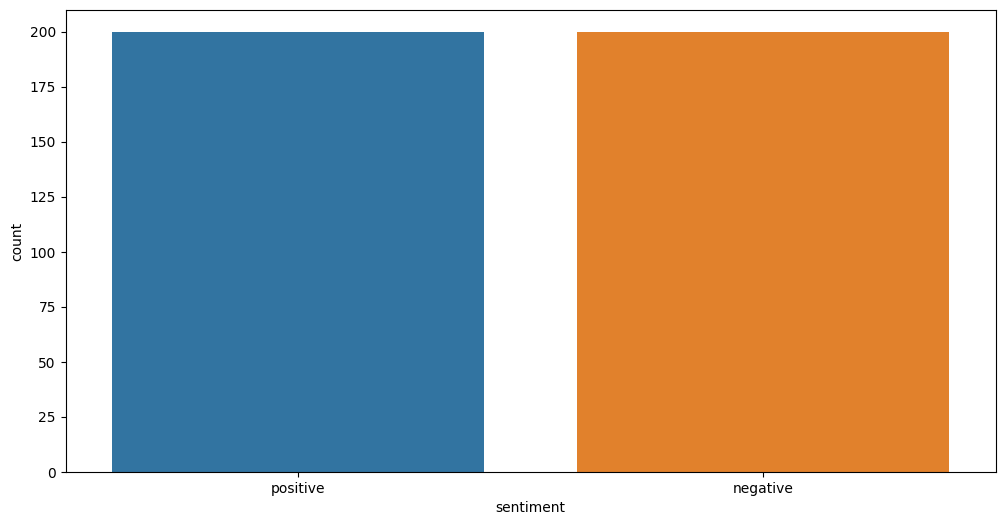

In [10]:
# Plot persebaran sentimen

plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=data)

> Data yang dimiliki dapat dikatakan balance karena pada fitur target memiliki nilai yang sama yaitu 200 pada senitmen positif dan 200 pada sentimen negatif.

In [11]:
STOPWORDS.add('https')  # remove htps to the world Cloud

def Plot_world(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 
        
        for words in tokens: 
          comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 5000, height = 4000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

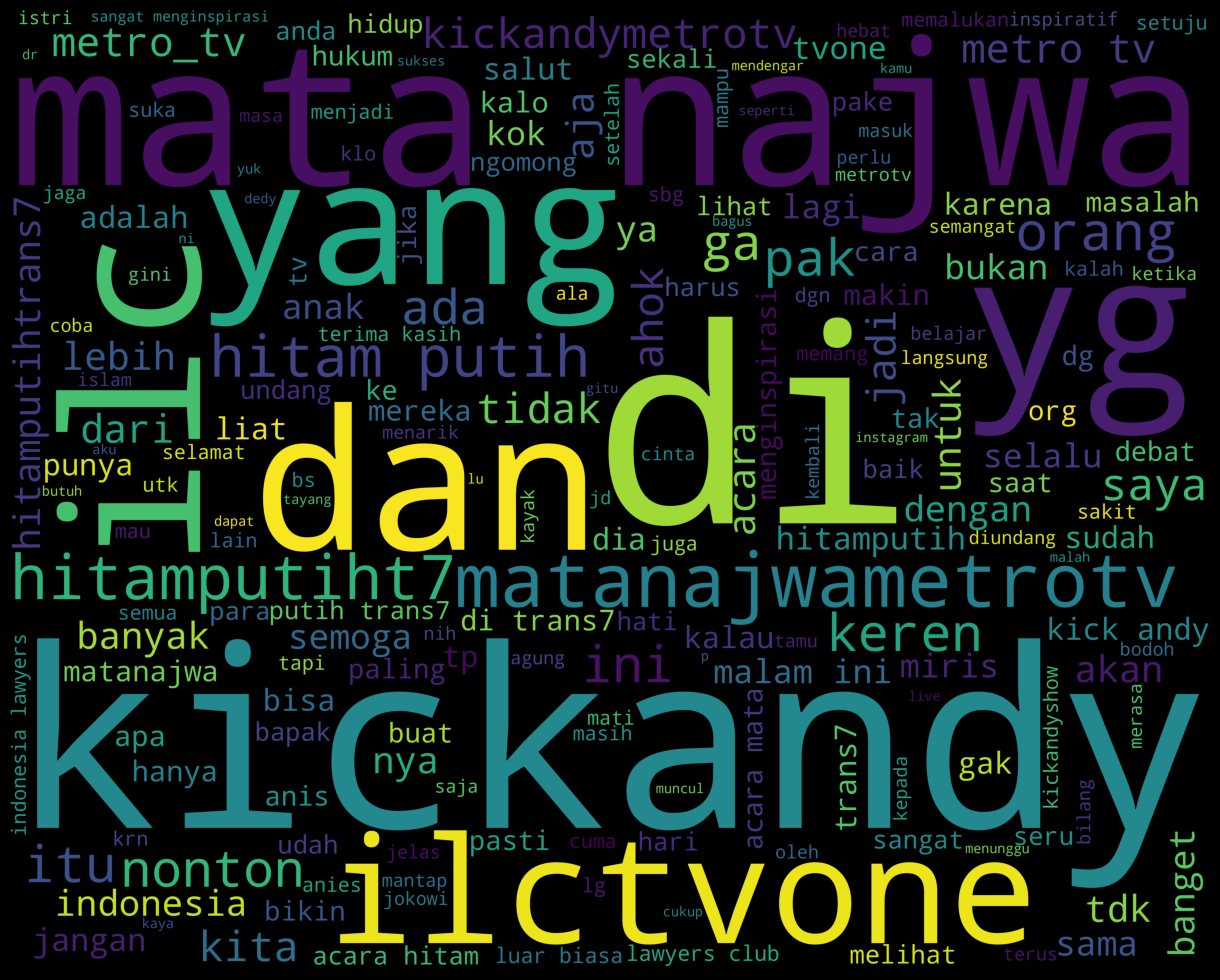

In [12]:
text = data.text.values

Plot_world(text)

> Gambar diatas menunjukkan kata yang paling sering muncul pada data sebelum dilakukan proses preprocessing.

#5. Feature Engineering

##5.1 Preprocessing data

In [19]:
# Mengubah Teks ke Lowercase

teks = data.text[42]
teks_lower = teks.lower()

# Menghilangkan Tanda Baca

teks_punc = teks_lower.translate(str.maketrans('', '', string.punctuation))

# Menghilangkan Mention
teks_punc = re.sub("@[A-Za-z0-9_]+", " ", teks_punc) 

# Menghilangkan Hashtag
teks_punc = re.sub("#[A-Za-z0-9_]+", " ", teks_punc)

# Menghilangkan Whitespace
teks_punc = teks_punc.strip()

# Menghilangkan Link
teks_punc = re.sub(r"http\S+", " ", teks_punc)
teks_punc = re.sub(r"www.\S+", " ", teks_punc)

# Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst
teks_punc = re.sub("[^A-Za-z\s']", " ", teks_punc)

# Menghilangkan RT
teks_punc = re.sub("rt", " ", teks_punc)

# Merapihkan Spaces
print('Sebelum preprocessing : ', teks_punc)
teks_punc = ' '.join(teks_punc.split())
print('Setelah preprocessing : ', teks_punc)

Sebelum preprocessing :  ada stefan lilipaly  andikvermansah di hitamputiht  keren
Setelah preprocessing :  ada stefan lilipaly andikvermansah di hitamputiht keren


In [20]:
# Stopwords
sw = list(set(stopwords.words('indonesian')))
sw = sw + ['dr', 'lu','utk','jd', 'org', 'gak','dng','tp', 'klo', 'mulu','bkin', 'ssk', 'ga', 'deh', 'aja', 'tau', 'ya','yg', 'kyk', 'mjkt', 'dpt', 'jkt', 'bs', 'yg', 'wahh', 'nih', 'ttg', 'lu', 'gw', 'gue', 'gua', 'ni', 'lg', 'n', 'tdk', 'sbg', 'nya', 'krn', 'hitamputiht'] # Cara lain dari "stpwds_id = stpwds_id + ['oh']"

tokens = word_tokenize(teks_punc)
teks_stopwords = ' '.join([word for word in tokens if word not in sw])

> Stopwords menggunakan NLTK dengan bahasa indonesia kemudian menambahkan secara manual stopwords terhadap singkatan dan kata slang.

In [21]:
# Stemming

factory = StemmerFactory()
stemmer = factory.create_stemmer()

teks_stemm  = stemmer.stem(teks_stopwords)

> Melakukan stemming dengan menggunkana sastrawi

In [22]:
# Fungsi preprocessing

def text_proses(teks):
  # ubah ke lowercase
  teks = teks.lower()
  
  #hapus mention
  teks = re.sub("@[A-Za-z0-9_]+", " ", teks)
  
  # hapus hashtag
  teks = re.sub("#[A-Za-z0-9_]+", " ", teks)
  
  # hapus whitespace
  teks = teks.strip()

  # hapus link
  teks = re.sub(r"http\S+", " ", teks)
  teks = re.sub(r"www.\S+", " ", teks)

  # hapus karakter selain huruf
  teks = re.sub("[^A-Za-z\s']", " ", teks)

  # tokenisasi
  tokens = word_tokenize(teks)

  # hapus stopword
  teks = ' '.join([word for word in tokens if word not in sw])
  
  # stemming
  teks = stemmer.stem(teks)
  
  return teks

In [23]:
# terapkan ke data

data['text_processed'] = data['text'].apply(lambda x: text_proses(x))
data

,sentiment,text,text_processed
0,positive,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S...",undang hitamputih menang layak undang prestasi
1,positive,Selamat berbuka puasa Semoga amal ibadah hari ...,selamat buka puasa moga amal ibadah terima allah
2,positive,"Ada nih di trans7 hitam putih, dia dpt penghar...",trans hitam putih harga norwegia
3,positive,selamat ya mas @adietaufan masuk hitamputih,selamat mas masuk hitamputih
4,positive,Asiknya nonton Hitam Putih Trans7,asiknya nonton hitam putih trans
...,...,...,...
395,negative,ini apa banget deh gw paling kesel klo orang2 ...,banget kesel orang debat pake emosi gin
396,negative,Orang miskin semakin miskin klo sekolah melaku...,orang miskin miskin sekolah pungut liar
397,negative,"ga boLeh emosi, cepat tua, nonton #matanajwame...",emosi cepat tua nonton lihat emosi bicara
398,negative,dr penampilan saja kyk preman taunya bkin kisr...,tampil preman tau kisruh usak


##5.2 Tentukan target

In [24]:
# Ubah target ke numerik

data['label'] = data['sentiment'].replace({'negative' : 0, 'positive' : 1})
data

,sentiment,text,text_processed,label
0,positive,"Undang @N_ShaniJKT48 ke hitamputih, pemenang S...",undang hitamputih menang layak undang prestasi,1
1,positive,Selamat berbuka puasa Semoga amal ibadah hari ...,selamat buka puasa moga amal ibadah terima allah,1
2,positive,"Ada nih di trans7 hitam putih, dia dpt penghar...",trans hitam putih harga norwegia,1
3,positive,selamat ya mas @adietaufan masuk hitamputih,selamat mas masuk hitamputih,1
4,positive,Asiknya nonton Hitam Putih Trans7,asiknya nonton hitam putih trans,1
...,...,...,...,...
395,negative,ini apa banget deh gw paling kesel klo orang2 ...,banget kesel orang debat pake emosi gin,0
396,negative,Orang miskin semakin miskin klo sekolah melaku...,orang miskin miskin sekolah pungut liar,0
397,negative,"ga boLeh emosi, cepat tua, nonton #matanajwame...",emosi cepat tua nonton lihat emosi bicara,0
398,negative,dr penampilan saja kyk preman taunya bkin kisr...,tampil preman tau kisruh usak,0


> Melakukan perubahan dari sentimen yang bernilai positive dan negative menjadi 1 untuk positive dan 0 untuk negative dan disimpan pada fitur baru bernama label.

##5.3 Tokenisasi dan Word Embedding

###5.3.1 Split data

In [25]:
#Split data

X_train, X_test, y_train, y_test = train_test_split(data.text_processed, 
                                                    data.label, 
                                                    test_size=0.25, 
                                                    random_state=93, 
                                                    stratify=data.label)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (300,)
Test Size  :  (100,)


> Melakukan spliting data menjadi X_train, X_test, y_train dan y_test yang mana data yang digunakan merupakan data pada fitur text_processed dan fitur label.

> Perbandingan data traindan test adalah 75:25 dan diacak menggunakan random state dengan nilai 93.

> Data ini akan digunakan pada pemodelan.

### 5.3.2 Tokenization

In [26]:
# ambil data yang akan dilakukan vektorisasi sebelum tokenisasi

Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

In [27]:
X_train_vec

<300x923 sparse matrix of type '<class 'numpy.int64'>'
	with 1855 stored elements in Compressed Sparse Row format>

In [28]:
X_test_vec

<100x923 sparse matrix of type '<class 'numpy.int64'>'
	with 387 stored elements in Compressed Sparse Row format>

> Pada X_train terdapat 1861 elemen kata dan X_test 389 elemen kata.

In [29]:
# hitung jumlah vocab dan kata dalam satu kalimat X_train

vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print("Jumlah vocab : ", vocab)
print("Panjang maksimum kata dalam kalimat : ", max_sen_len, "kata")

Jumlah vocab :  923
Panjang maksimum kata dalam kalimat :  17 kata


In [30]:
# hitung jumlah vocab dan kata dalam satu kalimat X_test

vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_test])

print("Jumlah vocab : ", vocab)
print("Panjang maksimum kata dalam kalimat : ", max_sen_len, "kata")

Jumlah vocab :  923
Panjang maksimum kata dalam kalimat :  15 kata


In [31]:
# Text vectorization

text_vectorization = TextVectorization(max_tokens=vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,) 
                                       )
text_vectorization.adapt(X_train)

> Vektorisasi pada X_train denan menerapkan banyak token sebanyak vocab yang dimiliki di X_train, dan banyak token per kalimat maksimal adalah 17 sesuai dengan max_sen_len.

In [32]:
# Tampilkan 15 token dengan frekuansi kemunculan terbesar

text_vectorization.get_vocabulary()[:15]

['',
 '[UNK]',
 'mata',
 'najwa',
 'acara',
 'hitam',
 'putih',
 'nonton',
 'orang',
 'tv',
 'keren',
 'indonesia',
 'metro',
 'ahok',
 'banget']

### 5.3.3 Embedding

In [33]:
# Embedding

embedding = Embedding(input_dim=vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

In [34]:
# Contoh setelah tokenisasi, vektorisasi dan embedding

## Contoh Document
print('Contoh Document')
print(data.text_processed[199])
print('')

## Hasil Text Vectorization
print('Hasil Text Vectorization')
print(text_vectorization([data.text_processed[199]]))
print('Ukuran vector : ', text_vectorization([data.text_processed[199]]).shape)
print('')

## Hasil Embedding
print('Hasil Embedding')
print(embedding(text_vectorization([data.text_processed[199]])))
print('Ukuran vector : ', embedding(text_vectorization([data.text_processed[199]])).shape)

Contoh Document
bicara ribet

Hasil Text Vectorization
tf.Tensor([[ 91 460   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 15), dtype=int64)
Ukuran vector :  (1, 15)

Hasil Embedding
tf.Tensor(
[[[-0.00752362  0.00364159  0.04688651 ...  0.01763607 -0.00888692
   -0.02247757]
  [-0.00140022 -0.01464368  0.04155231 ... -0.02338173 -0.02362655
   -0.00118339]
  [ 0.01771143 -0.03402748 -0.04502386 ... -0.00716246  0.03539086
    0.01458739]
  ...
  [ 0.01771143 -0.03402748 -0.04502386 ... -0.00716246  0.03539086
    0.01458739]
  [ 0.01771143 -0.03402748 -0.04502386 ... -0.00716246  0.03539086
    0.01458739]
  [ 0.01771143 -0.03402748 -0.04502386 ... -0.00716246  0.03539086
    0.01458739]]], shape=(1, 15, 128), dtype=float32)
Ukuran vector :  (1, 15, 128)


## 5.4 Encoding Target Menggunkaan OHE

In [35]:
# Tampilkan 5 sample y_train
y_train.sample(5)

101    1
371    0
149    1
6      1
272    0
Name: label, dtype: int64

In [36]:
# Mengubah Target ke dalam One Hot Encoding

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

#6. Modeling

## 6.1 LSTM Baseline

###6.1.1 Model Definition

In [37]:
# Definisikan model
model_lstm_base = Sequential()
model_lstm_base.add(text_vectorization)
model_lstm_base.add(embedding)
model_lstm_base.add(LSTM(8, return_sequences=True, kernel_regularizer=regularizers.L1(l1=0.1)))
model_lstm_base.add(LSTM(8, return_sequences=True))
model_lstm_base.add(LSTM(32))
model_lstm_base.add(Dense(2,activation='sigmoid'))

# Compile
model_lstm_base.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

model_lstm_base.summary()

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           118144    
                                                                 
 lstm (LSTM)                 (None, 15, 8)             4384      
                                                                 
 lstm_1 (LSTM)               (None, 15, 8)             544       
                                                                 
 lstm_2 (LSTM)               (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                        

> Pada model LSTM base saya menggunakan 2 hidden layer LSTM dnegan menggunakan kernel regularisasi L1L2, menggunakan fungsi aktivasi sigmoid pada output layer, loss menggunalan binary_crossentropy karena ini merupakan klasifikasi biner, optimizer adam dan metric yang digunakan accuracy.

> Pada model ini juga diterpakan early stop dengan metric yang diamati 'val_loss' dengan patience=10 dan mode auto.

###6.1.2 Model Training

In [38]:
# Train Model
lstm_base = model_lstm_base.fit(X_train,
                                y_train_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_test, y_test_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
10/10 [==============================] - 16s 347ms/step - loss: 38.4270 - accuracy: 0.4733 - val_loss: 36.1377 - val_accuracy: 0.5000
Epoch 2/300
10/10 [==============================] - 2s 215ms/step - loss: 34.5433 - accuracy: 0.6133 - val_loss: 32.3875 - val_accuracy: 0.5700
Epoch 3/300
10/10 [==============================] - 2s 151ms/step - loss: 30.8649 - accuracy: 0.7233 - val_loss: 28.8287 - val_accuracy: 0.5700
Epoch 4/300
10/10 [==============================] - 1s 74ms/step - loss: 27.3673 - accuracy: 0.7733 - val_loss: 25.4652 - val_accuracy: 0.5700
Epoch 5/300
10/10 [==============================] - 1s 74ms/step - loss: 23.9641 - accuracy: 0.8267 - val_loss: 22.2281 - val_accuracy: 0.7300
Epoch 6/300
10/10 [==============================] - 1s 76ms/step - loss: 20.7343 - accuracy: 0.9733 - val_loss: 19.3127 - val_accuracy: 0.8100
Epoch 7/300
10/10 [==============================] - 0s 54ms/step - loss: 17.8266 - accuracy: 0.9967 - val_loss: 16.6600 - val_accur

###6.1.3 Model Evaluation

In [39]:
# Create DataFrame

history_lstm_base_train = pd.DataFrame(lstm_base.history)
history_lstm_base_train

,loss,accuracy,val_loss,val_accuracy
0,38.426991,0.473333,36.137691,0.50
1,34.543251,0.613333,32.387527,0.57
2,30.864922,0.723333,28.828726,0.57
3,27.367344,0.773333,25.465157,0.57
4,23.964106,0.826667,22.228065,0.73
5,20.734343,0.973333,19.312733,0.81
6,17.826630,0.996667,16.659979,0.81
7,15.169858,0.996667,14.243092,0.81
8,12.755408,1.000000,11.968331,0.82
9,10.546643,1.000000,9.917541,0.82


<Axes: >

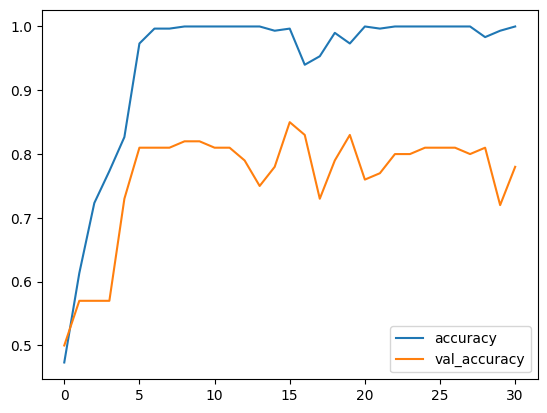

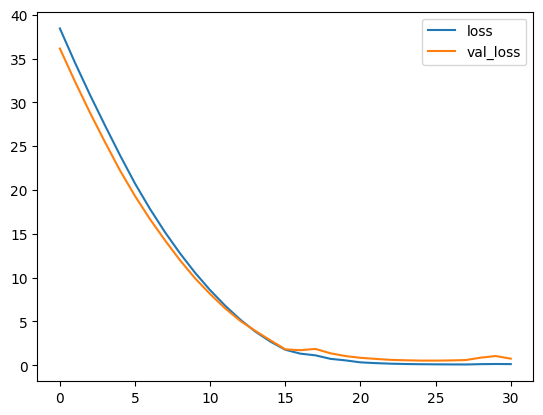

In [40]:
# Plot Training Results

history_lstm_base_train[['accuracy', 'val_accuracy']].plot()
history_lstm_base_train[['loss', 'val_loss']].plot()

In [41]:
# Test Model
lstm_base_test = model_lstm_base.fit(X_test,
                                y_test_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_train, y_train_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
4/4 [==============================] - 1s 225ms/step - loss: 0.7196 - accuracy: 0.8000 - val_loss: 2.0575 - val_accuracy: 0.5033
Epoch 2/300
4/4 [==============================] - 1s 160ms/step - loss: 2.1138 - accuracy: 0.5700 - val_loss: 0.2989 - val_accuracy: 1.0000
Epoch 3/300
4/4 [==============================] - 0s 156ms/step - loss: 0.8945 - accuracy: 0.8300 - val_loss: 0.4610 - val_accuracy: 1.0000
Epoch 4/300
4/4 [==============================] - 1s 162ms/step - loss: 0.8711 - accuracy: 0.8600 - val_loss: 0.4888 - val_accuracy: 1.0000
Epoch 5/300
4/4 [==============================] - 1s 153ms/step - loss: 0.7773 - accuracy: 0.8900 - val_loss: 0.4413 - val_accuracy: 1.0000
Epoch 6/300
4/4 [==============================] - 1s 140ms/step - loss: 0.6245 - accuracy: 0.9000 - val_loss: 0.3880 - val_accuracy: 1.0000
Epoch 7/300
4/4 [==============================] - 0s 91ms/step - loss: 0.4556 - accuracy: 0.9500 - val_loss: 0.3542 - val_accuracy: 1.0000
Epoch 7: early

In [42]:
# Create DataFrame

history_lstm_base_test = pd.DataFrame(lstm_base_test.history)
history_lstm_base_test

,loss,accuracy,val_loss,val_accuracy
0,0.719596,0.80,2.057539,0.503333
1,2.113778,0.57,0.298891,1.000000
2,0.894451,0.83,0.461050,1.000000
3,0.871087,0.86,0.488751,1.000000
4,0.777292,0.89,0.441331,1.000000
5,0.624505,0.90,0.387958,1.000000
6,0.455647,0.95,0.354209,1.000000


<Axes: >

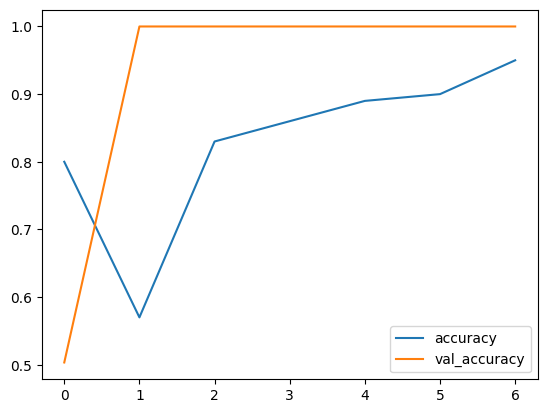

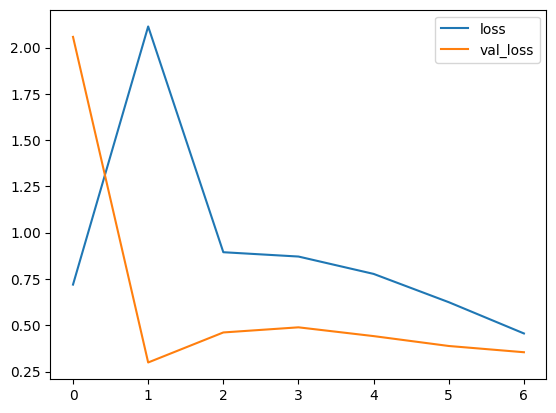

In [43]:
# Plot Training Results

history_lstm_base_test[['accuracy', 'val_accuracy']].plot()
history_lstm_base_test[['loss', 'val_loss']].plot()

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

# Model Evaluation of train-set
y_pred_1 = model_lstm_base.predict(X_train)
y_pred_1 = np.where(y_pred_1 >= 0.5, 1, 0)

print("Accuracy Train : ", accuracy_score(y_train_ohe, y_pred_1))

# Model Evaluation of test-set
y_pred = model_lstm_base.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

print("Accuracy Test : ", accuracy_score(y_test_ohe, y_pred))

10/10 [==============================] - 1s 4ms/step
Accuracy Train :  1.0
4/4 [==============================] - 0s 4ms/step
Accuracy Test :  0.97


## 6.2 GRU Baseline

###6.2.1 Model Definition

In [45]:
# Definisikan model
model_gru_base = Sequential()
model_gru_base.add(text_vectorization)
model_gru_base.add(embedding)
model_gru_base.add(GRU(32, return_sequences=True,))
model_gru_base.add(GRU(32))
model_gru_base.add(Dense(2,activation='sigmoid'))

model_gru_base.compile(loss='binary_crossentropy',optimizer='SGD',metrics='accuracy')

model_gru_base.summary()

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           118144    
                                                                 
 gru (GRU)                   (None, 15, 32)            15552     
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 140,098
Trainable params: 140,098
Non-trainable params: 0
________________________________________________

> Pada model LSTM base saya menggunakan 2 hidden layer LSTM dnegan menggunakan kernel regularisasi L1L2, menggunakan fungsi aktivasi sigmoid pada output layer, loss menggunalan binary_crossentropy karena ini merupakan klasifikasi biner, optimizer SGD dan metric yang digunakan accuracy.

> Pada model ini juga diterpakan early stop dengan metric yang diamati 'val_loss' dengan patience=10 dan mode auto.

###6.2.2 Model Training

In [46]:
# Train Model
gru_base = model_gru_base.fit(X_train,
                                y_train_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_test, y_test_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
10/10 [==============================] - 5s 170ms/step - loss: 0.6956 - accuracy: 0.4733 - val_loss: 0.6952 - val_accuracy: 0.4700
Epoch 2/300
10/10 [==============================] - 1s 87ms/step - loss: 0.6955 - accuracy: 0.4867 - val_loss: 0.6951 - val_accuracy: 0.4800
Epoch 3/300
10/10 [==============================] - 0s 39ms/step - loss: 0.6954 - accuracy: 0.4733 - val_loss: 0.6951 - val_accuracy: 0.4700
Epoch 4/300
10/10 [==============================] - 1s 59ms/step - loss: 0.6953 - accuracy: 0.4533 - val_loss: 0.6950 - val_accuracy: 0.4700
Epoch 5/300
10/10 [==============================] - 0s 51ms/step - loss: 0.6954 - accuracy: 0.4767 - val_loss: 0.6949 - val_accuracy: 0.4400
Epoch 6/300
10/10 [==============================] - 1s 64ms/step - loss: 0.6952 - accuracy: 0.4500 - val_loss: 0.6949 - val_accuracy: 0.4400
Epoch 7/300
10/10 [==============================] - 0s 30ms/step - loss: 0.6951 - accuracy: 0.4400 - val_loss: 0.6948 - val_accuracy: 0.4300
Epoch

###6.2.3 Model Evaluation

In [47]:
# Create DataFrame

history_gru_base_train = pd.DataFrame(gru_base.history)
history_gru_base_train

,loss,accuracy,val_loss,val_accuracy
0,0.695577,0.473333,0.695232,0.47
1,0.695492,0.486667,0.695131,0.48
2,0.695406,0.473333,0.695060,0.47
3,0.695304,0.453333,0.695040,0.47
4,0.695360,0.476667,0.694925,0.44
...,...,...,...,...
295,0.682803,0.600000,0.685037,0.59
296,0.682705,0.590000,0.684924,0.59
297,0.682565,0.596667,0.684827,0.59
298,0.682487,0.600000,0.684710,0.59


<Axes: >

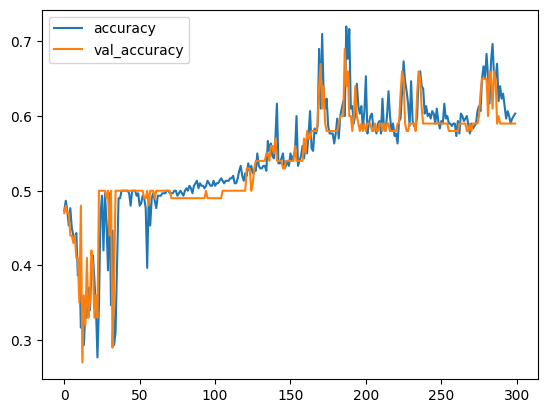

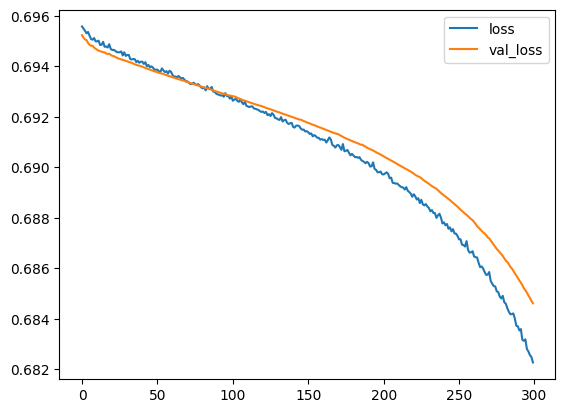

In [48]:
# Plot Training Results

history_gru_base_train[['accuracy', 'val_accuracy']].plot()
history_gru_base_train[['loss', 'val_loss']].plot()

In [49]:
# Test Model
gru_base_test = model_gru_base.fit(X_test,
                                y_test_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_train, y_train_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
4/4 [==============================] - 1s 119ms/step - loss: 0.6847 - accuracy: 0.5900 - val_loss: 0.6820 - val_accuracy: 0.6133
Epoch 2/300
4/4 [==============================] - 0s 88ms/step - loss: 0.6845 - accuracy: 0.5900 - val_loss: 0.6819 - val_accuracy: 0.6133
Epoch 3/300
4/4 [==============================] - 0s 82ms/step - loss: 0.6846 - accuracy: 0.5900 - val_loss: 0.6821 - val_accuracy: 0.5833
Epoch 4/300
4/4 [==============================] - 0s 84ms/step - loss: 0.6845 - accuracy: 0.5800 - val_loss: 0.6820 - val_accuracy: 0.5867
Epoch 5/300
4/4 [==============================] - 0s 112ms/step - loss: 0.6846 - accuracy: 0.5900 - val_loss: 0.6823 - val_accuracy: 0.5600
Epoch 6/300
4/4 [==============================] - 0s 63ms/step - loss: 0.6847 - accuracy: 0.5600 - val_loss: 0.6820 - val_accuracy: 0.5800
Epoch 7/300
4/4 [==============================] - 0s 85ms/step - loss: 0.6847 - accuracy: 0.5700 - val_loss: 0.6819 - val_accuracy: 0.5833
Epoch 8/300
4/4 [=

In [50]:
# Create DataFrame

history_gru_base_test = pd.DataFrame(gru_base_test.history)
history_gru_base_test

,loss,accuracy,val_loss,val_accuracy
0,0.684671,0.59,0.681999,0.613333
1,0.684507,0.59,0.681947,0.613333
2,0.684557,0.59,0.682070,0.583333
3,0.684522,0.58,0.682008,0.586667
4,0.684594,0.59,0.682257,0.560000
...,...,...,...,...
70,0.680702,0.68,0.678045,0.730000
71,0.680456,0.68,0.678105,0.760000
72,0.680572,0.70,0.678192,0.723333
73,0.680669,0.63,0.678074,0.756667


<Axes: >

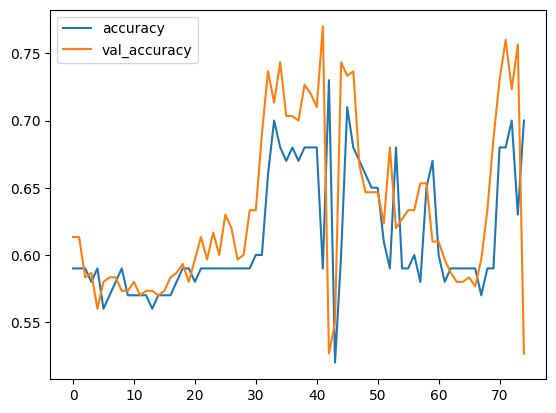

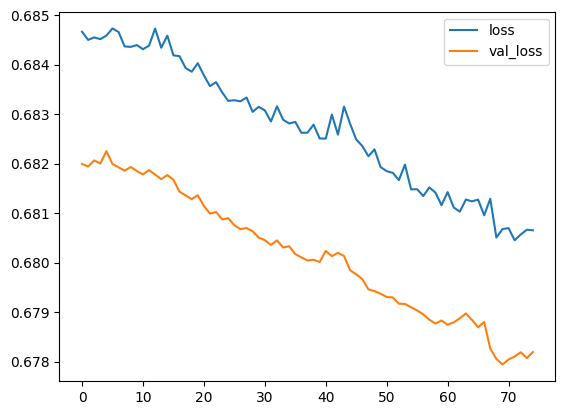

In [51]:
# Plot Training Results

history_gru_base_test[['accuracy', 'val_accuracy']].plot()
history_gru_base_test[['loss', 'val_loss']].plot()

In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

# Model Evaluation of test-set
y_pred_1 = model_gru_base.predict(X_train)
y_pred_1 = np.where(y_pred_1 >= 0.5, 1, 0)

print("Accuracy Train : ", accuracy_score(y_train_ohe, y_pred_1))


y_pred = model_gru_base.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

print("Accuracy Test : ", accuracy_score(y_test_ohe, y_pred))

10/10 [==============================] - 1s 3ms/step
Accuracy Train :  0.52
4/4 [==============================] - 0s 4ms/step
Accuracy Test :  0.51


## 6.3 LSTM Improved

###6.3.1 Model Definition

In [71]:
# Definisikan model
model_lstm_imp = Sequential()
model_lstm_imp.add(text_vectorization)
model_lstm_imp.add(embedding)
model_lstm_imp.add(tf.keras.layers.BatchNormalization())
model_lstm_imp.add(LSTM(8, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model_lstm_imp.add(tf.keras.layers.BatchNormalization())
model_lstm_imp.add(LSTM(16, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model_lstm_imp.add(tf.keras.layers.BatchNormalization())
model_lstm_imp.add(LSTM(32, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model_lstm_imp.add(tf.keras.layers.BatchNormalization())
model_lstm_imp.add(LSTM(32))
model_lstm_imp.add(Dropout(0.2))
model_lstm_imp.add(Dense(2,activation='sigmoid'))

# Compile
model_lstm_imp.compile(loss='binary_crossentropy',optimizer='SGD', metrics='accuracy')

model_lstm_imp.summary()

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           118144    
                                                                 
 batch_normalization_8 (Batc  (None, 15, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_11 (LSTM)              (None, 15, 8)             4384      
                                                                 
 batch_normalization_9 (Batc  (None, 15, 8)            32        
 hNormalization)                                                 
                                                      

> Pada model LSTM base saya menggunakan 2 hidden layer LSTM dnegan menggunakan kernel regularisasi L1L2, menggunakan fungsi aktivasi sigmoid pada output layer, loss menggunalan binary_crossentropy karena ini merupakan klasifikasi biner, optimizer SGD dan metric yang digunakan accuracy.

> Pada model ini juga diterpakan early stop dengan metric yang diamati 'val_loss' dengan patience=10 dan mode auto.

###6.3.2 Model Training

In [72]:
# Train Model
%%time
lstm_imp_train = model_lstm_imp.fit(X_train,
                                y_train_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_test, y_test_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
10/10 [==============================] - 10s 237ms/step - loss: 0.6256 - accuracy: 0.7767 - val_loss: 0.7084 - val_accuracy: 0.5000
Epoch 2/300
10/10 [==============================] - 1s 52ms/step - loss: 0.5177 - accuracy: 0.9600 - val_loss: 0.7076 - val_accuracy: 0.5100
Epoch 3/300
10/10 [==============================] - 1s 64ms/step - loss: 0.4600 - accuracy: 0.9700 - val_loss: 0.7066 - val_accuracy: 0.5200
Epoch 4/300
10/10 [==============================] - 1s 49ms/step - loss: 0.4113 - accuracy: 0.9800 - val_loss: 0.7054 - val_accuracy: 0.5400
Epoch 5/300
10/10 [==============================] - 0s 30ms/step - loss: 0.3707 - accuracy: 0.9833 - val_loss: 0.7036 - val_accuracy: 0.5700
Epoch 6/300
10/10 [==============================] - 0s 39ms/step - loss: 0.3493 - accuracy: 0.9800 - val_loss: 0.7015 - val_accuracy: 0.6500
Epoch 7/300
10/10 [==============================] - 0s 22ms/step - loss: 0.3116 - accuracy: 1.0000 - val_loss: 0.6987 - val_accuracy: 0.6800
Epoc

###6.3.3 Model Evaluation

In [73]:
# Create DataFrame

history_lstm_imp_train = pd.DataFrame(lstm_imp_train.history)
history_lstm_imp_train

,loss,accuracy,val_loss,val_accuracy
0,0.625586,0.776667,0.708379,0.50
1,0.517710,0.960000,0.707604,0.51
2,0.460029,0.970000,0.706561,0.52
3,0.411313,0.980000,0.705414,0.54
4,0.370697,0.983333,0.703587,0.57
5,0.349337,0.980000,0.701526,0.65
6,0.311553,1.000000,0.698703,0.68
7,0.310813,0.970000,0.695461,0.72
8,0.291568,0.966667,0.691188,0.72
9,0.263286,0.986667,0.687259,0.75


<Axes: >

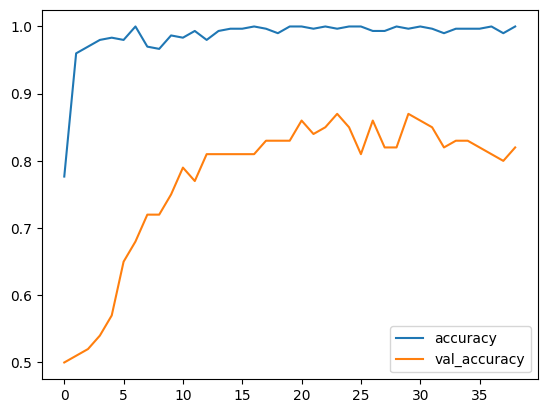

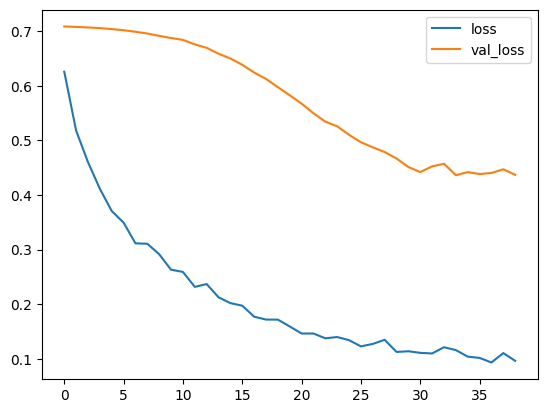

In [74]:
# Plot Training Results

history_lstm_imp_train[['accuracy', 'val_accuracy']].plot()
history_lstm_imp_train[['loss', 'val_loss']].plot()

In [77]:
# Test Model
%%time
lstm_imp_test = model_lstm_imp.fit(X_test,
                                y_test_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_train, y_train_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
4/4 [==============================] - 0s 95ms/step - loss: 0.1977 - accuracy: 0.9400 - val_loss: 0.1132 - val_accuracy: 0.9967
Epoch 2/300
4/4 [==============================] - 0s 37ms/step - loss: 0.2313 - accuracy: 0.9500 - val_loss: 0.2240 - val_accuracy: 0.9400
Epoch 3/300
4/4 [==============================] - 0s 70ms/step - loss: 0.2782 - accuracy: 0.9100 - val_loss: 0.1314 - val_accuracy: 1.0000
Epoch 4/300
4/4 [==============================] - 0s 71ms/step - loss: 0.1651 - accuracy: 1.0000 - val_loss: 0.1080 - val_accuracy: 1.0000
Epoch 5/300
4/4 [==============================] - 0s 41ms/step - loss: 0.1353 - accuracy: 0.9800 - val_loss: 0.1028 - val_accuracy: 1.0000
Epoch 6/300
4/4 [==============================] - 0s 52ms/step - loss: 0.1395 - accuracy: 0.9800 - val_loss: 0.0964 - val_accuracy: 1.0000
Epoch 7/300
4/4 [==============================] - 0s 37ms/step - loss: 0.1832 - accuracy: 0.9700 - val_loss: 0.1137 - val_accuracy: 1.0000
Epoch 8/300
4/4 [===

In [78]:
# Create DataFrame

history_lstm_imp_test = pd.DataFrame(lstm_imp_test.history)
history_lstm_imp_test

,loss,accuracy,val_loss,val_accuracy
0,0.197652,0.94,0.113222,0.996667
1,0.231323,0.95,0.223970,0.940000
2,0.278166,0.91,0.131381,1.000000
3,0.165070,1.00,0.108012,1.000000
4,0.135343,0.98,0.102822,1.000000
5,0.139535,0.98,0.096392,1.000000
6,0.183211,0.97,0.113723,1.000000
7,0.183230,0.98,0.098276,1.000000
8,0.129103,0.99,0.095690,1.000000
9,0.123617,0.99,0.092114,1.000000


<Axes: >

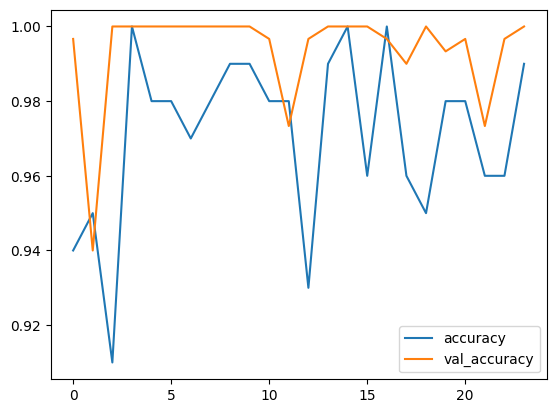

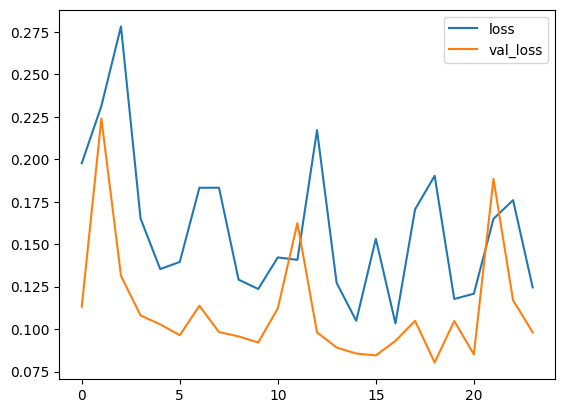

In [79]:
# Plot Training Results

history_lstm_imp_test[['accuracy', 'val_accuracy']].plot()
history_lstm_imp_test[['loss', 'val_loss']].plot()

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

# Model Evaluation of train-set
y_pred_1 = model_gru_base.predict(X_train)
y_pred_1 = np.where(y_pred_1 >= 0.5, 1, 0)

print("Accuracy Train : ", accuracy_score(y_train_ohe, y_pred_1))

# Model Evaluation of test-set
y_pred = model_gru_base.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

print("Accuracy Test : ", accuracy_score(y_test_ohe, y_pred))

10/10 [==============================] - 0s 3ms/step
Accuracy Train :  0.64
4/4 [==============================] - 0s 4ms/step
Accuracy Test :  0.62


## 6.4 GRU Improved

###6.4.1 Model Definition

In [98]:
# Definisikan model
model_gru_imp = Sequential()
model_gru_imp.add(text_vectorization)
model_gru_imp.add(embedding)
model_gru_imp.add(tf.keras.layers.BatchNormalization())
model_gru_imp.add(GRU(32, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model_gru_imp.add(tf.keras.layers.BatchNormalization())
model_gru_imp.add(GRU(32, return_sequences=True, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))
model_gru_imp.add(GRU(64))
model_gru_imp.add(tf.keras.layers.BatchNormalization())
model_gru_imp.add(Dense(2,activation='sigmoid'))

model_gru_imp.compile(loss='binary_crossentropy',optimizer='SGD',metrics='accuracy')

model_gru_imp.summary()

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           118144    
                                                                 
 batch_normalization_28 (Bat  (None, 15, 128)          512       
 chNormalization)                                                
                                                                 
 gru_15 (GRU)                (None, 15, 32)            15552     
                                                                 
 batch_normalization_29 (Bat  (None, 15, 32)           128       
 chNormalization)                                                
                                                     

> Pada model GRU improved saya menggunakan 3 hidden layer GRU dnegan menggunakan kernel regularisasi L1L2, menggunakan fungsi aktivasi sigmoid pada output layer, loss menggunalan binary_crossentropy karena ini merupakan klasifikasi biner, optimizer SGD dan metric yang digunakan accuracy.

> Pada model ini juga diterpakan early stop dengan metric yang diamati 'val_loss' dengan patience=10 dan mode auto.

###6.4.2 Model Training

In [102]:
# Train Model
gru_imp_train = model_gru_imp.fit(X_train,
                                y_train_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_test, y_test_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
10/10 [==============================] - 0s 42ms/step - loss: 0.0518 - accuracy: 1.0000 - val_loss: 0.7113 - val_accuracy: 0.5200
Epoch 2/300
10/10 [==============================] - 0s 35ms/step - loss: 0.0793 - accuracy: 0.9867 - val_loss: 0.6652 - val_accuracy: 0.5300
Epoch 3/300
10/10 [==============================] - 0s 26ms/step - loss: 0.0491 - accuracy: 1.0000 - val_loss: 0.6856 - val_accuracy: 0.5300
Epoch 4/300
10/10 [==============================] - 0s 34ms/step - loss: 0.0578 - accuracy: 0.9933 - val_loss: 0.6658 - val_accuracy: 0.5300
Epoch 5/300
10/10 [==============================] - 0s 41ms/step - loss: 0.0518 - accuracy: 1.0000 - val_loss: 0.6033 - val_accuracy: 0.6200
Epoch 6/300
10/10 [==============================] - 0s 32ms/step - loss: 0.0608 - accuracy: 0.9967 - val_loss: 0.6575 - val_accuracy: 0.5500
Epoch 7/300
10/10 [==============================] - 0s 26ms/step - loss: 0.0494 - accuracy: 1.0000 - val_loss: 0.6231 - val_accuracy: 0.6200
Epoch 

###6.4.3 Model Evaluation

In [103]:
# Create DataFrame

history_gru_imp_train = pd.DataFrame(gru_imp_train.history)
history_gru_imp_train

,loss,accuracy,val_loss,val_accuracy
0,0.051815,1.000000,0.711270,0.52
1,0.079288,0.986667,0.665230,0.53
2,0.049141,1.000000,0.685602,0.53
3,0.057801,0.993333,0.665761,0.53
4,0.051767,1.000000,0.603291,0.62
5,0.060837,0.996667,0.657493,0.55
6,0.049376,1.000000,0.623136,0.62
7,0.047858,1.000000,0.654044,0.59
8,0.054849,1.000000,0.587996,0.69
9,0.051761,1.000000,0.527615,0.75


<Axes: >

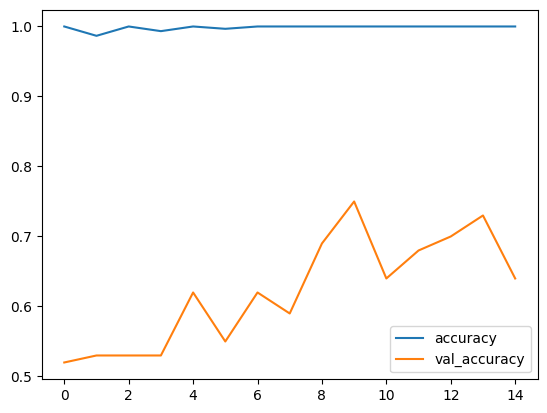

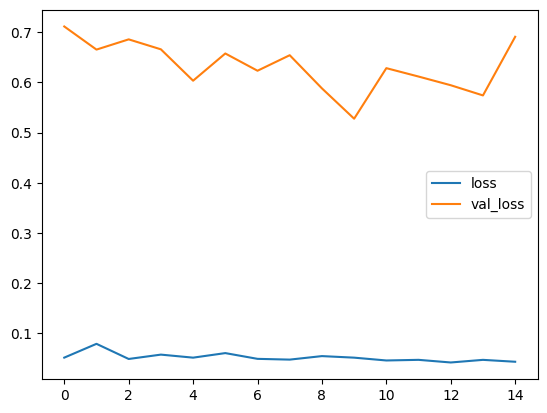

In [104]:
# Plot Training Results

history_gru_imp_train[['accuracy', 'val_accuracy']].plot()
history_gru_imp_train[['loss', 'val_loss']].plot()

In [105]:
# Train Model
gru_imp_test = model_gru_imp.fit(X_test,
                                y_test_ohe,
                                batch_size=batch,
                                epochs=300,
                                validation_data=(X_train, y_train_ohe),
                                callbacks=[earlystop_callback]
                                )

Epoch 1/300
4/4 [==============================] - 1s 138ms/step - loss: 0.3758 - accuracy: 0.8300 - val_loss: 0.7863 - val_accuracy: 0.7000
Epoch 2/300
4/4 [==============================] - 0s 90ms/step - loss: 0.3239 - accuracy: 0.8700 - val_loss: 0.1932 - val_accuracy: 0.9900
Epoch 3/300
4/4 [==============================] - 0s 78ms/step - loss: 0.0944 - accuracy: 0.9900 - val_loss: 0.1863 - val_accuracy: 0.9900
Epoch 4/300
4/4 [==============================] - 0s 62ms/step - loss: 0.1055 - accuracy: 0.9800 - val_loss: 0.6855 - val_accuracy: 0.5600
Epoch 5/300
4/4 [==============================] - 0s 63ms/step - loss: 0.1882 - accuracy: 0.9200 - val_loss: 0.8965 - val_accuracy: 0.5467
Epoch 6/300
4/4 [==============================] - 0s 57ms/step - loss: 0.1430 - accuracy: 0.9400 - val_loss: 2.2204 - val_accuracy: 0.5167
Epoch 7/300
4/4 [==============================] - 0s 63ms/step - loss: 0.1834 - accuracy: 0.9500 - val_loss: 0.4514 - val_accuracy: 0.7067
Epoch 8/300
4/4 [==

In [106]:
# Create DataFrame

history_gru_imp_test = pd.DataFrame(gru_imp_test.history)
history_gru_imp_test

,loss,accuracy,val_loss,val_accuracy
0,0.375840,0.83,0.786319,0.700000
1,0.323925,0.87,0.193236,0.990000
2,0.094357,0.99,0.186281,0.990000
3,0.105512,0.98,0.685537,0.560000
4,0.188201,0.92,0.896455,0.546667
5,0.143048,0.94,2.220361,0.516667
6,0.183395,0.95,0.451364,0.706667
7,0.096344,0.99,0.176062,0.980000
8,0.150836,0.98,0.443453,0.720000
9,0.160380,0.94,0.579979,0.623333


<Axes: >

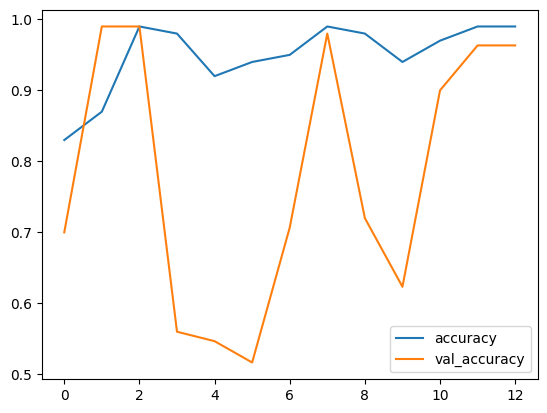

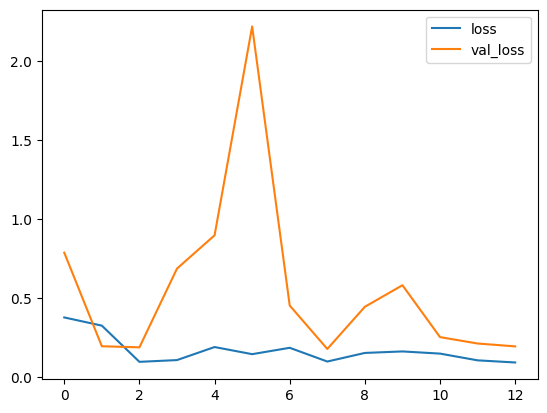

In [107]:
# Plot Test Results

history_gru_imp_test[['accuracy', 'val_accuracy']].plot()
history_gru_imp_test[['loss', 'val_loss']].plot()

In [108]:
# Model Evaluation of train-set
y_pred_1 = model_gru_imp.predict(X_train)
y_pred_1 = np.where(y_pred_1 >= 0.5, 1, 0)

print("Accuracy Train : ", accuracy_score(y_train_ohe, y_pred_1))

# Model Evaluation of test-set
y_pred = model_gru_imp.predict(X_test)
y_pred = np.where(y_pred >= 0.5, 1, 0)

print("Accuracy Test : ", accuracy_score(y_test_ohe, y_pred))

10/10 [==============================] - 1s 5ms/step
Accuracy Train :  0.9566666666666667
4/4 [==============================] - 0s 6ms/step
Accuracy Test :  0.9


# 7. Model Saving

In [ ]:
# Save Model

model_gru_imp.save('model_gru_imp.h5')

> Model GRU Improved disimpan karena model ini memiliki akurasi train sebesar 1.0 dan akurasi test 0.89. Hasil ini merupakan akurasi tertinggi dibanding denganmodel lainnya.

# 8. Kesimpulan

> Berdasarkan model yang dibuat, model GRU improvement memiliki akurasi terbaik.

> Setiap Model menggunakan sequential API.

> Pada model GRU Impreovemnt dilakukan penambahan 3 layer batch normalization, penambahan layer GRU menjadi 3 hidden layer GRU.

> Setiap model yang saya kerjakan menggunakan epoch 300 namum saya terpakan earlystop dengan patience = 10 dimana ketika nilai val_los tidak memiliki perubahan setelah 5 epoch maka proses train akan dihentikan. Batch yang saya gunakan sebanyak 32.
